<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic_csv = '../../DATA/titanic_train.csv'
df=pd.read_csv(titanic_csv, index_col='PassengerId')

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
# Overview of numerical values
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# What type of data do we have?
df.dtypes


Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [5]:
# Let's add a new column for sex as a NUMERIC rather than OBJECT
# 1 = male
df['Sex_num'] = df['Sex'].apply(lambda x: 1 if x[:1] is 'm' else 0 if x[:1] is 'f' else np.NaN)
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
Sex_num       int64
dtype: object

In [6]:
# Let's take a look at a sample
df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num
PassengerId,,,,,,,,,,,,
332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S,1
315,0,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S,1
842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.5000,NaN,S,1
112,0,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,0
573,1,1,"Flynn, Mr. John Irwin (""Irving"")",male,36.0,0,0,PC 17474,26.3875,E25,S,1


In [7]:
# How many missing values do we have?
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Sex_num       0
dtype: int64

In [8]:
# Good news - our prediction variable (Survived) is fully specified
#
# Bad news - a lot of missing age value & cabin. Do we care?
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_num
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333
Sex_num,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000


In [9]:
# Most highly correclated with Survived is
#
# Sex of person
# PClass
# Fare
#
# We don't care about AGE since not much correlation with survived

In [10]:
# Let's look a bit more deeply at the underlying data
import pandas_profiling
p = pandas_profiling.ProfileReport(df)
p.to_widgets()

In [11]:
# ANSWER
print(df.groupby("Survived").mean())

            Pclass        Age     SibSp     Parch       Fare   Sex_num
Survived                                                              
0         2.531876  30.626179  0.553734  0.329690  22.117887  0.852459
1         1.950292  28.343690  0.473684  0.464912  48.395408  0.318713


In [12]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [13]:
# ANSWER
feature_cols = ['Pclass', 'Parch']

X = df[feature_cols]
y = df['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [14]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [15]:
# ANSWER
# Create Model
logreg = LogisticRegression(solver='liblinear',max_iter=100)

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [16]:
# ANSWER
# Fit Model
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [17]:
# ANSWER
print(logreg.coef_)
# with radnom_state =1 is [[-0.86727899  0.26584821]]

[[-0.74876339  0.28700193]]


The computed intercept (`intercept_`) is the 1st element of another array:

In [18]:
# ANSWER
print(logreg.intercept_)
# with random_state = 1, is [1.5219749]

[1.11960059]


We can create tuples of the predictor names and coefficients like this:

In [19]:
# ANSWER
print(set(zip(feature_cols, logreg.coef_[0])))

{('Parch', 0.2870019307556956), ('Pclass', -0.7487633939794467)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [20]:
for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.748763
Parch       +0.287002


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [21]:
# ANSWER
#
res = (logreg.predict_proba(X_train)[:,1] > .5) + y_train
#print(res)
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_train.count())

accuracy_score = correct / y_train.count()
print("TRAIN DATA: Accuracy score = ", accuracy_score)


Correct predictions  453  out of  668
TRAIN DATA: Accuracy score =  0.6781437125748503


What is the  `accuracy_score` for the test data?

In [22]:
# ANSWER
res = (logreg.predict_proba(X_test)[:,1] > .5) + y_test
#print(res)
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_test.count())

accuracy_score = correct / y_test.count()
print("TEST DATA: Accuracy score = ", accuracy_score)


Correct predictions  157  out of  223
TEST DATA: Accuracy score =  0.7040358744394619


What can we say aout this result?

ANSWER
- Our regression is giving a slightly better result than on test data
- Would want to try again using different sets of test/train

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

Number male missing 124
Number female missing 53


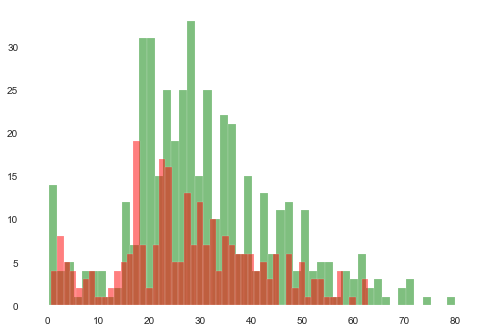

In [23]:
# ANSWER
# Check out Age
def age_hist(df, bins=50):
    """Display a histogram of age v. sex."""
    plt.hist(df[df['Sex']=='male']['Age'], bins=bins, color="green", alpha=0.5)
    plt.hist(df[df['Sex']=='female']['Age'], bins=bins, color="red", alpha=0.5)
    print("Number male missing", df[df['Sex']=='male']['Age'].isna().sum())
    print("Number female missing", df[df['Sex']=='female']['Age'].isna().sum())
age_hist(df)

Number male missing 0
Number female missing 0


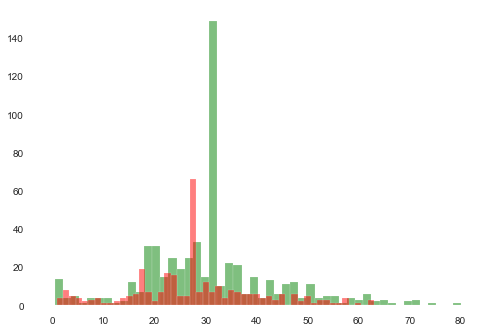

In [24]:
nage = df.groupby(["Parch", "Sex"])["Age"].transform(lambda x: x.fillna(x.mean()))
nage = df.groupby(["Sex"])["Age"].transform(lambda x: x.fillna(x.mean()))
#ndf = df.groupby(["Parch"])["Age"].transform(lambda x: x.fillna(x.mean()))
ndf = df.copy()
ndf["Age"] = nage
age_hist(ndf)

In [25]:
# Even though adding the mean age for missing values skews the age data, we'll give it a go!
#
df["Age"] = ndf["Age"]

In [26]:
# Build Model
feature_cols = ['Pclass', 'Parch', 'Age']

X = df[feature_cols]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg = LogisticRegression(solver='liblinear',max_iter=100)

# Fit Model
logreg.fit(X_train, y_train)

# Score
res = (logreg.predict_proba(X_test)[:,1] > .5) + y_test
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_test.count())

accuracy_score = correct / y_test.count()
print("TEST DATA: Accuracy score = ", accuracy_score)

Correct predictions  151  out of  223
TEST DATA: Accuracy score =  0.6771300448430493


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

As expected, not much improvement. This is likely because:

- The age is not correlated particularly well with Survival - we previously found R = -0.077221
- Although there are slightly less CORRECT predictions (151 instead of 156) this could be due to random sample selection
- ...

Let's see where the model is going wrong by showing the Confusion Matrix:

In [27]:
# ANSWER
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[111  17]
 [ 55  40]]


Nb. Here is how `confusion_matrix` arranges its output:

In [28]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: 
False Negatives are more prevalent.
This means we are incorrectly predicting deaths.

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

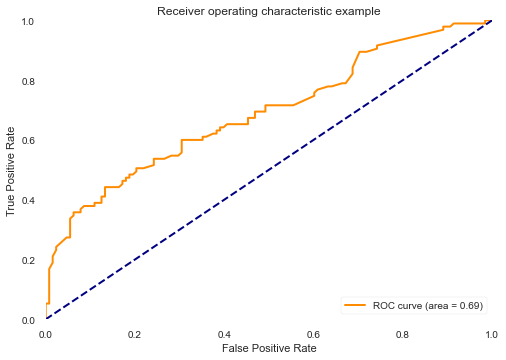

In [29]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Save for later
fpr1 = fpr
tpr1 = tpr
roc_auc1 = roc_auc

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [30]:
metrics.confusion_matrix(y_test, logreg.predict(X_test))

array([[111,  17],
       [ 55,  40]], dtype=int64)

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [31]:
# Reload our data again
df=pd.read_csv(titanic_csv, index_col='PassengerId')

titanic_with_dummies = pd.get_dummies(data = df, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.sample(10)

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
406,0,"Gale, Mr. Shadrach",34.0,1,0,28664,21.0000,NaN,0,1,0,0,1,0,1,0
255,0,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",41.0,0,2,370129,20.2125,NaN,1,0,0,0,1,0,0,1
593,0,"Elsbury, Mr. William James",47.0,0,0,A/5 3902,7.2500,NaN,0,1,0,0,1,0,0,1
766,1,"Hogeboom, Mrs. John C (Anna Andrews)",51.0,1,0,13502,77.9583,D11,1,0,0,0,1,1,0,0
224,0,"Nenkoff, Mr. Christo",NaN,0,0,349234,7.8958,NaN,0,1,0,0,1,0,0,1
403,0,"Jussila, Miss. Mari Aina",21.0,1,0,4137,9.8250,NaN,1,0,0,0,1,0,0,1
37,1,"Mamee, Mr. Hanna",NaN,0,0,2677,7.2292,NaN,0,1,1,0,0,0,0,1
723,0,"Gillespie, Mr. William Henry",34.0,0,0,12233,13.0000,NaN,0,1,0,0,1,0,1,0
163,0,"Bengtsson, Mr. John Viktor",26.0,0,0,347068,7.7750,NaN,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [32]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))
titanic_with_dummies.sample(10)

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
6,0,"Moran, Mr. James",28.816667,0,0,330877,8.4583,NaN,0,1,0,1,0,0,0,1
116,0,"Pekoniemi, Mr. Edvard",21.000000,0,0,STON/O 2. 3101294,7.9250,NaN,0,1,0,0,1,0,0,1
775,1,"Hocking, Mrs. Elizabeth (Eliza Needs)",54.000000,1,3,29105,23.0000,NaN,1,0,0,0,1,0,1,0
59,1,"West, Miss. Constance Mirium",5.000000,1,2,C.A. 34651,27.7500,NaN,1,0,0,0,1,0,1,0
188,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",45.000000,0,0,111428,26.5500,NaN,0,1,0,0,1,1,0,0
318,0,"Moraweck, Dr. Ernest",54.000000,0,0,29011,14.0000,NaN,0,1,0,0,1,0,1,0
544,1,"Beane, Mr. Edward",32.000000,1,0,2908,26.0000,NaN,0,1,0,0,1,0,1,0
467,0,"Campbell, Mr. William",33.631250,0,0,239853,0.0000,NaN,0,1,0,0,1,0,1,0
300,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",50.000000,0,1,PC 17558,247.5208,B58 B60,1,0,1,0,0,1,0,0


Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [33]:
# ANSWER
# Set Feature Both Numerical, Categorical
# Build Model
feature_cols = ["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]

X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg = LogisticRegression(solver='liblinear',max_iter=100)

# Fit Model
logreg.fit(X_train, y_train)
print("Accuracy score ", logreg.score(X_test, y_test))

# Score
#res = (logreg.predict_proba(X_test)[:,1] > .5) + y_test
res = logreg.predict(X_test) + y_test
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_test.count())

accuracy_score = correct / y_test.count()
print("TEST DATA: Accuracy score = ", accuracy_score)


Accuracy score  0.7982062780269058
Correct predictions  178  out of  223
TEST DATA: Accuracy score =  0.7982062780269058


Plot the ROC curve for the new model:

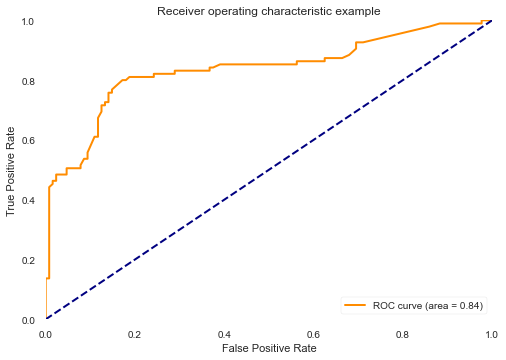

In [34]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [35]:
titanic_with_dummies.dtypes

Survived        int64
Name           object
Age           float64
SibSp           int64
Parch           int64
Ticket         object
Fare          float64
Cabin          object
Sex_female      uint8
Sex_male        uint8
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
Pclass_1        uint8
Pclass_2        uint8
Pclass_3        uint8
dtype: object

Can we improve the model by including the remaining features?

In [36]:
# ANSWER
# Build Model
feature_cols = ["Age", "Parch", "Fare", "Sex_male", "Pclass_1", "Pclass_2", "SibSp"]

X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg = LogisticRegression(solver='liblinear',max_iter=100)

# Fit Model
logreg.fit(X_train, y_train)
print("Accuracy score ", logreg.score(X_test, y_test))

# Score
res = (logreg.predict_proba(X_test)[:,1] > .5) + y_test
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_test.count())

accuracy_score = correct / y_test.count()
print("TEST DATA: Accuracy score = ", accuracy_score)

Accuracy score  0.820627802690583
Correct predictions  183  out of  223
TEST DATA: Accuracy score =  0.820627802690583


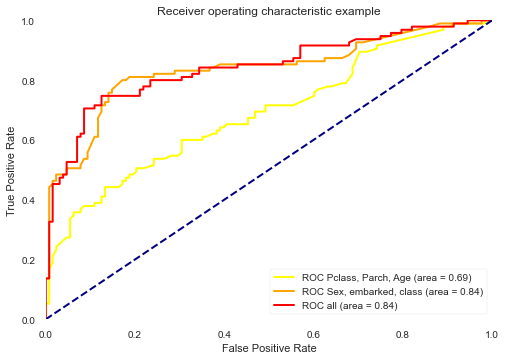

In [37]:
# ANSWER
#
# Let's plot both on same chart

# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr_all, tpr_all, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc_all = metrics.auc(fpr_all, tpr_all)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr1, tpr1, color='yellow', lw = lw, label = 'ROC Pclass, Parch, Age (area = %0.2f)' % roc_auc1)
plt.plot(fpr, tpr, color='orange', lw = lw, label = 'ROC Sex, embarked, class (area = %0.2f)' % roc_auc)
plt.plot(fpr_all, tpr_all, color='red', lw = lw, label = 'ROC all (area = %0.2f)' % roc_auc_all)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [38]:
# Conclusion
#
# Adding extra features didn't help us much since AUC although slightly different (orange & red)
# still have the same Area Under the Curve

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

<h2>1. random_state</h2>

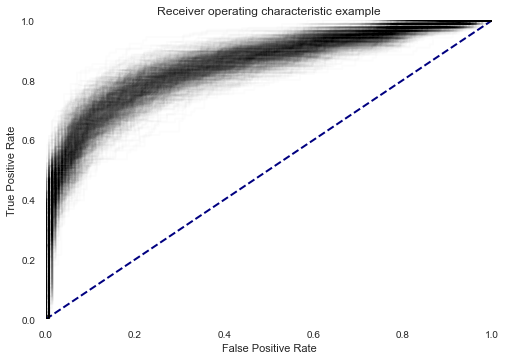

Correlation:
          Score     AUROC
Score  1.000000  0.729958
AUROC  0.729958  1.000000
             Score        AUROC
count  1000.000000  1000.000000
mean      0.801202     0.852715
std       0.024831     0.024075
min       0.708520     0.775164
25%       0.784753     0.837473
50%       0.802691     0.853167
75%       0.816143     0.869324
max       0.874439     0.921984


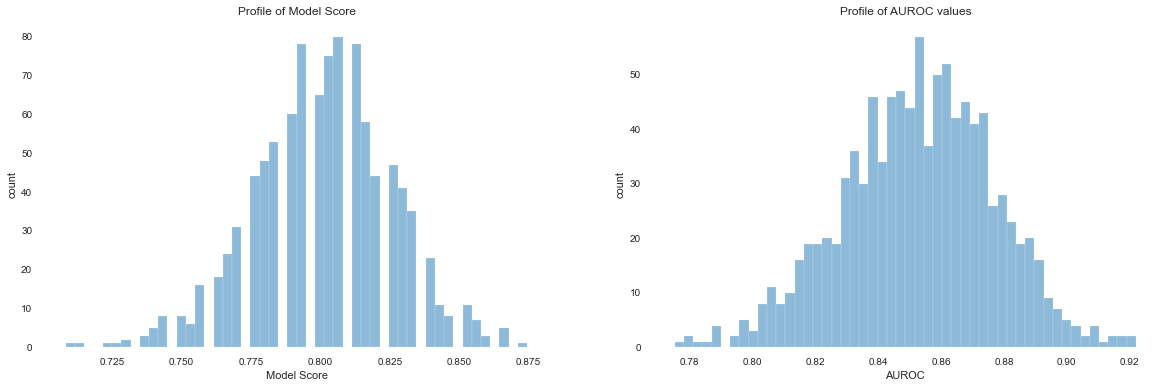

In [39]:
#
# Lets try using a number of different picks of the data
# We will compare results on two metrics:
#   Score - how well we predict the result
#   AUROC - which is c combination of the fpr & tpr vectors
#
# Use a function to do this to make it easy
#
# NOTE: Reverting back to the original fitting with AGE and PARCH
#
#feature_cols = ["Age", "Parch"]
feature_cols = ["Age", "Parch", "Fare", "Sex_male", "Pclass_1", "Pclass_2", "SibSp"]
X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']

def RunLogReg(X, y, runs):
    res = []
    plt.figure()
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')

    for i in range(runs):
        # Make selection fort this run and prepare model
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        logreg = LogisticRegression(solver='liblinear',max_iter=100)

        # Fit Model
        logreg.fit(X_train, y_train)
        
        # Find out predictions from the test data
        preds = logreg.predict_proba(X_test)[:,1]

        # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
        fpr, tpr, _ = metrics.roc_curve(y_test, preds)

        plt.plot(fpr, tpr, color='black', lw = lw, alpha=0.01)
        # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
        roc_auc = metrics.auc(fpr, tpr)

        res.append([logreg.score(X_test, y_test), roc_auc])
    plt.show()
    return res

# Convert into a data frame and give columns a name
# Do a large number of runs
r = pd.DataFrame(RunLogReg(X, y, 1000))
r.columns = ['Score', 'AUROC']

# Some information about the series of results
print("Correlation:")
print(r.corr())
print(r.describe())

# Lets see what they look like
plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.xlabel('Model Score')
plt.ylabel('count')
plt.title('Profile of Model Score')
plt.hist(r["Score"], bins=50, alpha=0.5)
plt.subplot(1, 2, 2)
plt.xlabel('AUROC')
plt.ylabel('count')
plt.title('Profile of AUROC values')
plt.hist(r["AUROC"], bins=50, alpha=0.5, label="AUROC")
plt.show()


In [40]:
# Using lots of different partitions of the data and then looking at the results produces a range of results
#
# The BEST fit we obtained is 0.879
# The WORST fit we have 0.726
#
# The chart shows what the curves look like when superimposed. We can see the "average" prediction
# and range of results.
#
# We have discovered
# Our origianl model with accuracy = 0.82 just happened to be in the top 75% of fits
# The aveage model achieves an accuracy of 0.80
# The range of area under the curve spans from 0.76 to 0.94
#
# We could argue that anything about a score of 50% is overfit and below is underfit
#
# QUESTION:
# Why does the Score Model have "gaps" in the calculated score? Is this an artifact of the althorigh? 
# Increasing/drecreasing number of runs just changes where the gaps are.

<h2>2. Cross validation</h2>

In [41]:
from sklearn.model_selection import cross_val_score
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
logreg = LogisticRegression()
scores = cross_val_score(logreg, titanic_with_dummies[feature_cols], titanic_with_dummies[target_col], cv=5)
scores.mean()


C:\DataScience\Anaconda\envs\p37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\DataScience\Anaconda\envs\p37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

0.8013621241604418

<h2>3. Look at vectors</h2>

In [42]:
# Build Model
logreg = LogisticRegression()

# Fit
logreg.fit(X_train, y_train)

# Predict
y_pred_class = logreg.predict(X_test)

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

C:\DataScience\Anaconda\envs\p37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[115  13]
 [ 28  67]]


In [43]:
# Calculate classification error or Misclassification Rate - this is how often we are wrong
#
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.18385650224215247
0.18385650224215244


In [44]:
# Sensitivity: When the actual value is positive, how often is the prediction correct?
#
# Also known as "True Positive Rate" or "Recall"
sensitivity = TP / float(FN + TP)
print(sensitivity)
print(metrics.recall_score(y_test, y_pred_class))

0.7052631578947368
0.7052631578947368


In [45]:
# Specificity - how often do we correctly give the NEGATIVE result?
specificity = TN / (TN + FP)

print(specificity)

0.8984375


In [46]:
# False positive rate - how often do we incorrectly give a POSTIVE Positive result?
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.1015625
0.1015625


In [47]:
# Precision - how often is our POSITIVE answer correct?
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.8375
0.8375




---



---



> > > > > > > > > © 2019 Institute of Data


---



---



